# TRABAJO PRACTICO INVOP
### Consigna 1: Licitación

#### 🏫 Generación de datos
- [X] Generar **709 escuelas** con coordenadas en un rectángulo predefinido.
- [ ] Crear un conjunto de **empresas ficticias** (A, B, C, ...).
- [ ] Generar **tres instancias distintas** de ofertas de las empresas para las escuelas.

#### 📊 Modelos de licitación
- [ ] Implementar el **modelo básico de licitación**.
- [ ] Ejecutar el modelo para **cada una de las tres instancias**.
- [ ] Implementar y correr el **modelo alternativo** que detecta si hay **más de un óptimo**.

#### 🧩 Unidades de Competencia (UC)
- [ ] Verificar que en **alguna instancia haya más de una empresa ganadora** en una misma UC.
- [ ] Seleccionar esa UC y **aplicar el algoritmo greedy de asignación** de escuelas dentro de ella.

#### 🧪 Validación y visualización
- [ ] Visualizar la **geolocalización de las escuelas** en el plano.
- [ ] Mostrar los **resultados de las licitaciones** y las **empresas ganadoras**.
- [ ] Analizar y comentar los **casos con múltiples óptimos**.


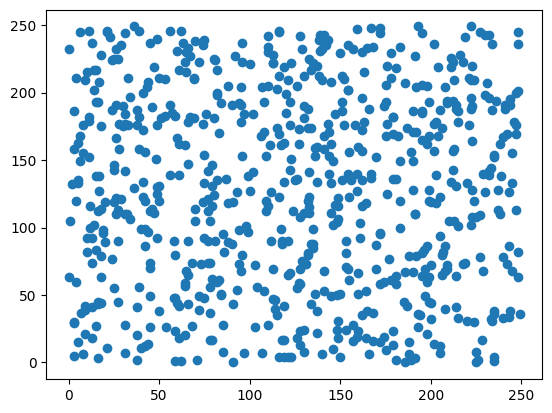

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
num_escuelas=709
diametro=250
rng = np.random.default_rng(1902)
rng2= np.random.default_rng(609)
escuelas_x = rng.integers(0,diametro, num_escuelas)
escuelas_y = rng2.integers(0,diametro,num_escuelas)
escuelas=np.array([escuelas_x,escuelas_y]).T
plt.scatter(escuelas[:,0],escuelas[:,1])

In [5]:
np.random.randint?

Signature: np.random.randint(low, high=None, size=None, dtype=<class 'int'>)
Docstring:
randint(low, high=None, size=None, dtype=int)

Return random integers from `low` (inclusive) to `high` (exclusive).

Return random integers from the "discrete uniform" distribution of
the specified dtype in the "half-open" interval [`low`, `high`). If
`high` is None (the default), then results are from [0, `low`).

.. note::
    New code should use the `~numpy.random.Generator.integers`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
low : int or array-like of ints
    Lowest (signed) integers to be drawn from the distribution (unless
    ``high=None``, in which case this parameter is one above the
    *highest* such integer).
high : int or array-like of ints, optional
    If provided, one above the largest (signed) integer to be drawn
    from the distribution (see above for behavior if ``high=None``).
    If array-lik